# Florence-2-large sample usage

In [35]:
from transformers import AutoProcessor, AutoModelForCausalLM  
from PIL import Image
import requests
import copy
import torch
%matplotlib inline  

In [36]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/home/usama-naveed/miniconda3/envs/hf/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## define the prediction function

In [38]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )
    return parsed_answer

## init image 

In [96]:
path = "/home/usama-naveed/Music/Florence-2_large/test.jpg"
image = Image.open((path))

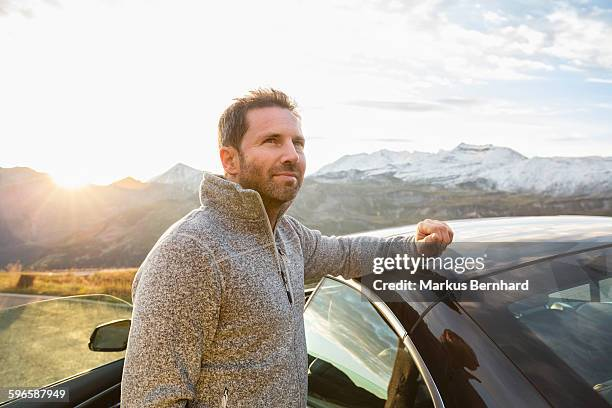

In [97]:
image

# Captioning Using Florence-2  
## Simple Prompts You Can Use

## Simple Caption

# ' < CAPTION >' 

## A little detailed Caption

# <DETAILED_CAPTION>

## A more detailed Caption

# <MORE_DETAILED_CAPTION>


In [43]:
task_prompt = '<CAPTION>'
run_example(task_prompt)

{'<CAPTION>': 'a man standing next to his car in the mountains'}

In [45]:
task_prompt = '<DETAILED_CAPTION>'
run_example(task_prompt)

{'<DETAILED_CAPTION>': 'The image shows a man standing next to his car on the side of a road, with the sun setting in the background and the mountains in the distance. The sky is a beautiful mix of oranges, pinks, and purples, and the grass is a lush green. There is a watermark on the image, adding a unique touch to the scene.'}

In [46]:
task_prompt = '<MORE_DETAILED_CAPTION>'
run_example(task_prompt)

{'<MORE_DETAILED_CAPTION>': 'The image shows a man standing next to a black car on a road with a beautiful mountain landscape in the background. The man is wearing a gray sweater and has a beard and is looking up at the sky with a smile on his face. The sun is shining brightly in the top left corner of the image, creating a warm glow over the scene. The mountains in the distance are covered in snow and the sky is blue with a few clouds. The overall mood of the photo is peaceful and serene.'}

# This will draw boxes with labels on the image you have provided 


### Object detection

OD results format: 
{'\<OD>':
    {
    'bboxes': [[x1, y1, x2, y2], ...], 
    'labels': ['label1', 'label2', ...]
    } 
}

In [47]:
task_prompt = '<OD>'
results = run_example(task_prompt)
print(results)

{'<OD>': {'bboxes': [[0.3059999942779541, 214.40399169921875, 611.0819702148438, 407.38800048828125], [235.92599487304688, 107.0999984741211, 306.9179992675781, 201.34799194335938], [115.9739990234375, 95.67599487304688, 453.1860046386719, 404.1239929199219]], 'labels': ['car', 'human face', 'man']}}


In [48]:
import matplotlib.pyplot as plt  
import matplotlib.patches as patches  
def plot_bbox(image, data):
   # Create a figure and axes  
    fig, ax = plt.subplots()  
      
    # Display the image  
    ax.imshow(image)  
      
    # Plot each bounding box  
    for bbox, label in zip(data['bboxes'], data['labels']):  
        # Unpack the bounding box coordinates  
        x1, y1, x2, y2 = bbox  
        # Create a Rectangle patch  
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')  
        # Add the rectangle to the Axes  
        ax.add_patch(rect)  
        # Annotate the label  
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))  
      
    # Remove the axis ticks and labels  
    ax.axis('off')  
      
    # Show the plot  
    plt.show()  

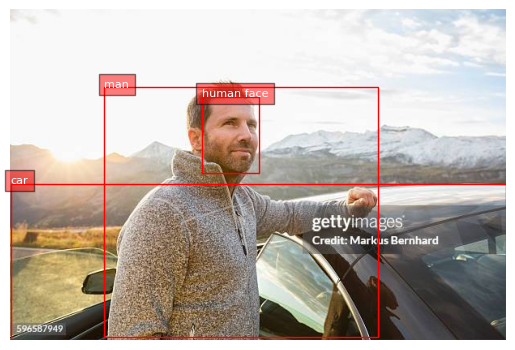

In [49]:
plot_bbox(image, results['<OD>'])

# Draw Boxes and give Captions on the region. 

### Dense region caption

Dense region caption results format: 
{'\<DENSE_REGION_CAPTION>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['label1', 'label2', ...]}}

In [50]:
task_prompt = '<DENSE_REGION_CAPTION>'
results = run_example(task_prompt)
print(results)

{'<DENSE_REGION_CAPTION>': {'bboxes': [[0.3059999942779541, 214.40399169921875, 611.0819702148438, 407.38800048828125], [115.36199951171875, 95.67599487304688, 453.1860046386719, 403.71600341796875], [235.92599487304688, 107.0999984741211, 306.9179992675781, 201.34799194335938]], 'labels': ['man opening car window on mountain road', 'man with car window tinting in mountain landscape', 'human face']}}


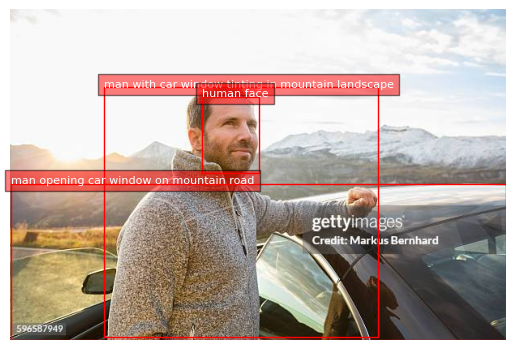

In [51]:
plot_bbox(image, results['<DENSE_REGION_CAPTION>'])

# This will help you draw BBs on a Region seen by the model.

### Region proposal

Region proposal results format: 
{'<REGION_PROPOSAL>' : {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [52]:
task_prompt = '<REGION_PROPOSAL>'
results = run_example(task_prompt)
print(results)

{'<REGION_PROPOSAL>': {'bboxes': [[0.3059999942779541, 214.40399169921875, 611.0819702148438, 407.38800048828125], [114.75, 95.67599487304688, 453.1860046386719, 403.71600341796875], [119.64599609375, 172.78799438476562, 425.64599609375, 407.38800048828125], [300.7980041503906, 214.40399169921875, 611.0819702148438, 406.97998046875], [301.4100036621094, 274.7879943847656, 436.6619873046875, 407.38800048828125], [210.83399963378906, 89.14799499511719, 313.6499938964844, 196.45199584960938], [235.92599487304688, 107.0999984741211, 306.9179992675781, 201.34799194335938], [87.8219985961914, 319.2599792480469, 131.88600158691406, 352.71600341796875]], 'labels': ['', '', '', '', '', '', '', '']}}


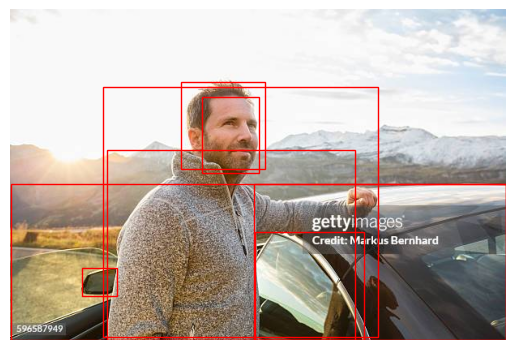

In [53]:
plot_bbox(image, results['<REGION_PROPOSAL>'])

## Run pre-defined tasks that requires additional inputs 

### Phrase Grounding
Phrase grounding results format: 
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [57]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="Only label the face")
print(results)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[238.37399291992188, 105.8759994506836, 306.9179992675781, 202.57199096679688]], 'labels': ['the face']}}


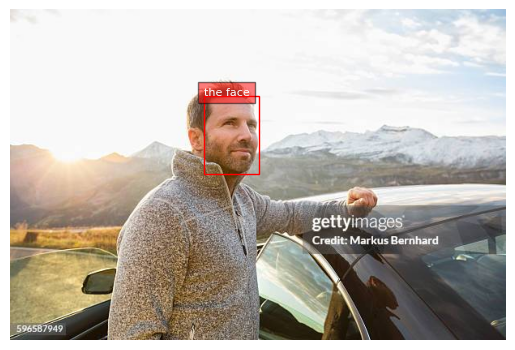

In [58]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Referring expression segmentation

Referring expression segmentation results format: 
{'\<REFERRING_EXPRESSION_SEGMENTATION>': {'Polygons': [[[polygon]], ...], 'labels': ['', '', ...]}}, one object is represented by a list of polygons. each polygon is [x1, y1, x2, y2, ..., xn, yn]

In [66]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(task_prompt, text_input="human")
print(results)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[233.47799682617188, 100.16400146484375, 235.31399536132812, 98.93999481201172, 238.37399291992188, 98.1240005493164, 241.43399047851562, 98.1240005493164, 244.49398803710938, 96.9000015258789, 246.3300018310547, 96.08399963378906, 248.16600036621094, 94.04399871826172, 248.16600036621094, 92.00399780273438, 250.61399841308594, 91.18799591064453, 254.28599548339844, 91.18799591064453, 257.34600830078125, 89.14799499511719, 260.406005859375, 89.14799499511719, 263.46600341796875, 89.14799499511719, 271.4219970703125, 89.14799499511719, 276.3179931640625, 89.96399688720703, 280.60198974609375, 91.18799591064453, 282.43798828125, 92.00399780273438, 285.49798583984375, 94.04399871826172, 288.5579833984375, 96.08399963378906, 290.39398193359375, 98.1240005493164, 293.4539794921875, 102.20399475097656, 295.2900085449219, 105.05999755859375, 296.5140075683594, 107.0999984741211, 296.5140075683594, 111.18000030517578, 297.7380065917969, 11

In [67]:
from PIL import Image, ImageDraw, ImageFont 
import random
import numpy as np
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
def draw_polygons(image, prediction, fill_mask=False):  
    """  
    Draws segmentation masks with polygons on an image.  
  
    Parameters:  
    - image_path: Path to the image file.  
    - prediction: Dictionary containing 'polygons' and 'labels' keys.  
                  'polygons' is a list of lists, each containing vertices of a polygon.  
                  'labels' is a list of labels corresponding to each polygon.  
    - fill_mask: Boolean indicating whether to fill the polygons with color.  
    """  
    # Load the image  
   
    draw = ImageDraw.Draw(image)  
      
   
    # Set up scale factor if needed (use 1 if not scaling)  
    scale = 1  
      
    # Iterate over polygons and labels  
    for polygons, label in zip(prediction['polygons'], prediction['labels']):  
        color = random.choice(colormap)  
        fill_color = random.choice(colormap) if fill_mask else None  
          
        for _polygon in polygons:  
            _polygon = np.array(_polygon).reshape(-1, 2)  
            if len(_polygon) < 3:  
                print('Invalid polygon:', _polygon)  
                continue  
              
            _polygon = (_polygon * scale).reshape(-1).tolist()  
              
            # Draw the polygon  
            if fill_mask:  
                draw.polygon(_polygon, outline=color, fill=fill_color)  
            else:  
                draw.polygon(_polygon, outline=color)  
              
            # Draw the label text  
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)  
  
    # Save or display the image  
    #image.show()  # Display the image  
    display(image)

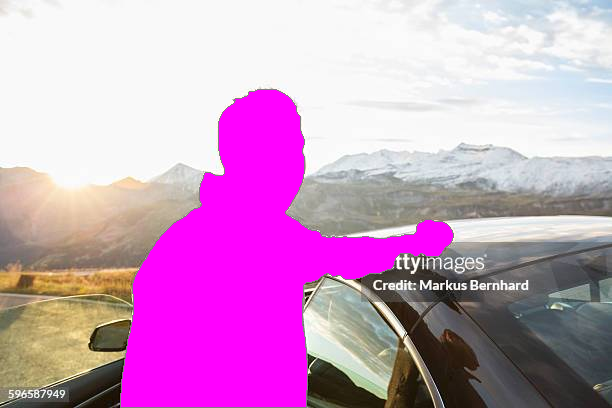

In [68]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)  

### region to segmentation


with additional region as inputs, format is '\<loc_x1>\<loc_y1>\<loc_x2>\<loc_y2>', [x1, y1, x2, y2] is the quantized corrdinates in [0, 999]. 

In [71]:
task_prompt = '<REGION_TO_SEGMENTATION>'
results = run_example(task_prompt, text_input="<loc_702><loc_575><loc_866><loc_562>")
print(results)

{'<REGION_TO_SEGMENTATION>': {'polygons': [[[430.5419921875, 236.0279998779297, 433.60198974609375, 234.8040008544922, 450.1259765625, 234.8040008544922, 452.5740051269531, 236.0279998779297, 452.5740051269531, 238.88400268554688, 451.3500061035156, 240.9239959716797, 450.1259765625, 242.9639892578125, 448.28997802734375, 243.77999877929688, 446.4539794921875, 245.00399780273438, 444.61798095703125, 245.00399780273438, 441.5579833984375, 245.00399780273438, 438.49798583984375, 245.00399780273438, 437.27398681640625, 243.77999877929688, 433.60198974609375, 242.9639892578125, 430.5419921875, 242.9639892578125, 428.70599365234375, 241.739990234375, 428.70599365234375, 238.88400268554688, 428.70599365234375, 236.843994140625]]], 'labels': ['']}}


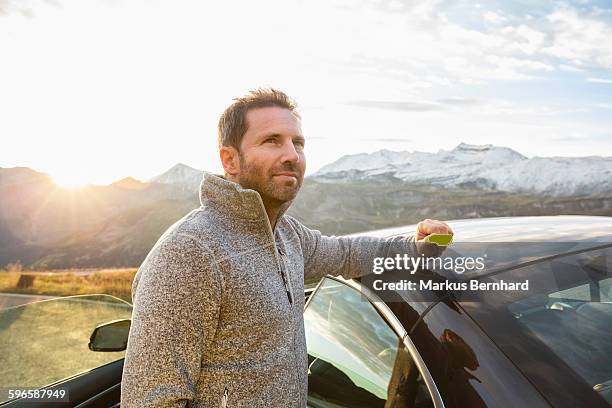

In [72]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REGION_TO_SEGMENTATION>'], fill_mask=True)  

### Open vocabulary detection

open vocabulary detection can detect both objects and ocr texts. 

results format: 

{ '\<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[x1, y1, x2, y2], [x1, y1, x2, y2], ...]], 'bboxes_labels': ['label_1', 'label_2', ..],
'polygons': [[[x1, y1, x2, y2, ..., xn, yn], [x1, y1, ..., xn, yn]], ...], 'polygons_labels': ['label_1', 'label_2', ...]
}}

In [81]:
task_prompt = '<OPEN_VOCABULARY_DETECTION>'
results = run_example(task_prompt, text_input="side mirror")
print(results)

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[86.5979995727539, 316.8119812011719, 132.4980010986328, 354.3479919433594]], 'bboxes_labels': ['side mirror'], 'polygons': [], 'polygons_labels': []}}


In [82]:
def convert_to_od_format(data):  
    """  
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.  
  
    Parameters:  
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.  
  
    Returns:  
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.  
    """  
    # Extract bounding boxes and labels  
    bboxes = data.get('bboxes', [])  
    labels = data.get('bboxes_labels', [])  
      
    # Construct the output format  
    od_results = {  
        'bboxes': bboxes,  
        'labels': labels  
    }  
      
    return od_results  

In [83]:
bbox_results  = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])

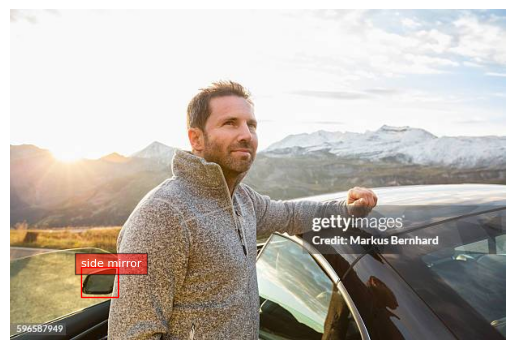

In [84]:
plot_bbox(image, bbox_results)

### region to texts

In [85]:
task_prompt = '<REGION_TO_CATEGORY>'
results = run_example(task_prompt, text_input="<loc_52><loc_332><loc_932><loc_774>")
print(results)

{'<REGION_TO_CATEGORY>': 'car<loc_52><loc_332><loc_932><loc_774>'}


In [86]:
task_prompt = '<REGION_TO_DESCRIPTION>'
results = run_example(task_prompt, text_input="<loc_52><loc_332><loc_932><loc_774>")
print(results)

{'<REGION_TO_DESCRIPTION>': 'man with car on mountain road with scenic view<loc_52><loc_332><loc_932><loc_774>'}


## ocr related tasks

In [87]:
url = "http://ecx.images-amazon.com/images/I/51UUzBDAMsL.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

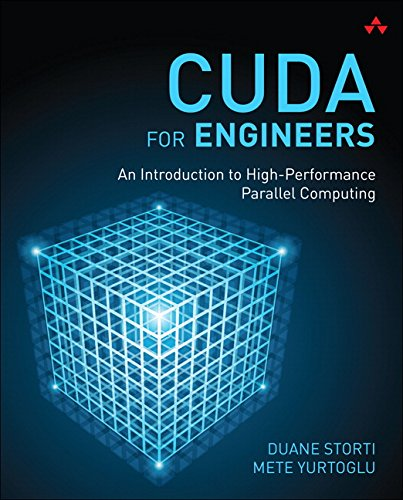

In [88]:
image

In [89]:
task_prompt = '<OCR>'
run_example(task_prompt)

{'<OCR>': 'CUDAFOR ENGINEERSAn Introduction to High-PerformanceParallel ComputingDUANE STORTIMETE YURTOGLU'}

In [90]:
task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt)
print(results)
# ocr results format
# {'OCR_WITH_REGION': {'quad_boxes': [[x1, y1, x2, y2, x3, y3, x4, y4], ...], 'labels': ['text1', ...]}}

{'<OCR_WITH_REGION>': {'quad_boxes': [[167.0435028076172, 50.25, 374.9914855957031, 50.25, 374.9914855957031, 114.75, 167.0435028076172, 114.75], [144.8784942626953, 120.75, 374.9914855957031, 120.75, 374.9914855957031, 149.25, 144.8784942626953, 149.25], [115.86249542236328, 165.25, 377.0065002441406, 166.25, 377.0065002441406, 184.25, 115.86249542236328, 183.25], [239.9864959716797, 184.25, 377.0065002441406, 186.25, 377.0065002441406, 204.25, 239.9864959716797, 202.25], [266.5845031738281, 441.25, 377.0065002441406, 441.25, 377.0065002441406, 456.25, 266.5845031738281, 456.25], [251.27049255371094, 460.25, 377.0065002441406, 460.25, 377.0065002441406, 475.25, 251.27049255371094, 475.25]], 'labels': ['</s>CUDA', 'FOR ENGINEERS', 'An Introduction to High-Performance', 'Parallel Computing', 'DUANE STORTI', 'METE YURTOGLU']}}


In [91]:
def draw_ocr_bboxes(image, prediction, scale=1):
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",
        
                    fill=color)
       
    display(image)

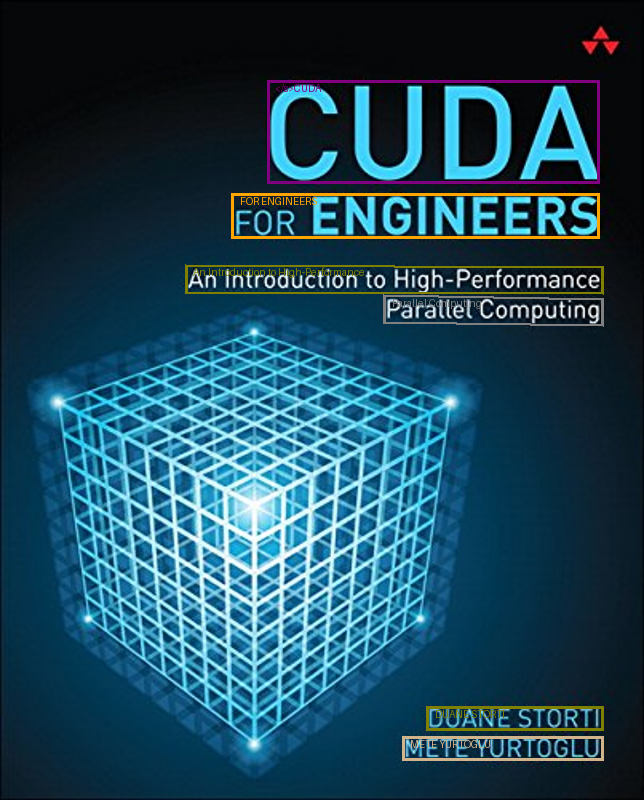

In [92]:
output_image = copy.deepcopy(image)
w, h = output_image.size
scale = 800 / max(w, h)
new_output_image = output_image.resize((int(w * scale), int(h * scale)))
draw_ocr_bboxes(new_output_image, results['<OCR_WITH_REGION>'], scale=scale)  

## Cascaded tasks

### Caption + Phrase Grounding 

results format: 

{
 '\<CAPTION': pure_text, 
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [32]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

In [98]:
task_prompt = '<CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<CAPTION>'] = text_input

In [99]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[118.4219970703125,
    87.51599884033203,
    456.8580017089844,
    407.38800048828125],
   [2.1419999599456787,
    213.99600219726562,
    611.0819702148438,
    407.38800048828125],
   [1.5299999713897705,
    140.96400451660156,
    611.0819702148438,
    272.3399963378906]],
  'labels': ['a man', 'his car', 'the mountains']},
 '<CAPTION>': 'a man standing next to his car in the mountains'}

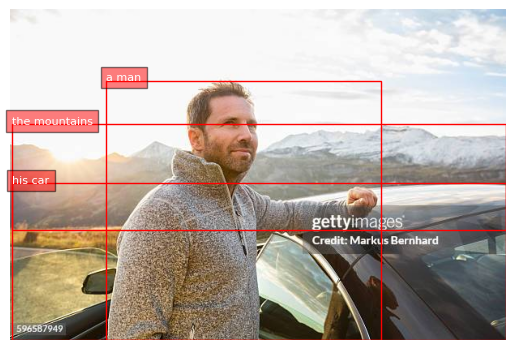

In [100]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Detailed Caption + Phrase Grounding 

results format: 

{
 '\<DETAILED_CAPTION': pure_text, 
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [101]:
task_prompt = '<DETAILED_CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<DETAILED_CAPTION>'] = text_input

In [102]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[118.4219970703125,
    87.51599884033203,
    456.2460021972656,
    406.97998046875],
   [2.753999948501587,
    213.58799743652344,
    611.0819702148438,
    407.38800048828125],
   [43.757999420166016,
    160.95599365234375,
    98.22599792480469,
    199.30799865722656],
   [2.1419999599456787, 140.55599975585938, 611.0819702148438, 270.7080078125],
   [1.5299999713897705,
    0.20399999618530273,
    611.0819702148438,
    178.90798950195312],
   [1.5299999713897705,
    267.4440002441406,
    136.78199768066406,
    404.94000244140625],
   [1.5299999713897705,
    290.6999816894531,
    133.7220001220703,
    404.94000244140625],
   [1.5299999713897705,
    266.62799072265625,
    138.00599670410156,
    305.38800048828125],
   [366.89398193359375,
    249.4919891357422,
    533.3579711914062,
    299.6759948730469],
   [2.753999948501587,
    383.7239990234375,
    71.90999603271484,
    405.7559814453125]],
  'labels': ['a man',


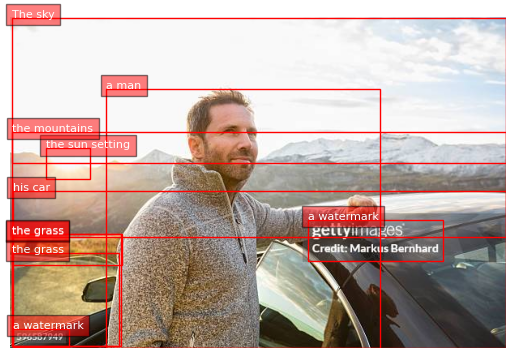

In [103]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### More Detailed Caption + Phrase Grounding 

results format: 

{
 '\<MORE_DETAILED_CAPTION': pure_text, 
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [104]:
task_prompt = '<MORE_DETAILED_CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<MORE_DETAILED_CAPTION>'] = text_input

In [105]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[119.03399658203125,
    87.10800170898438,
    454.4100036621094,
    406.16400146484375],
   [2.753999948501587, 213.17999267578125, 611.0819702148438, 406.97998046875],
   [119.03399658203125,
    87.51599884033203,
    453.7980041503906,
    406.16400146484375],
   [118.4219970703125, 172.37998962402344, 420.75, 406.97998046875],
   [235.31399536132812,
    151.97999572753906,
    305.6940002441406,
    204.61199951171875],
   [2.1419999599456787,
    0.20399999618530273,
    611.0819702148438,
    176.45999145507812],
   [238.37399291992188,
    105.8759994506836,
    308.1419982910156,
    203.79598999023438],
   [30.9060001373291,
    139.33200073242188,
    130.66200256347656,
    209.91600036621094],
   [40.697998046875,
    154.83599853515625,
    103.12200164794922,
    200.94000244140625],
   [2.753999948501587,
    139.33200073242188,
    611.0819702148438,
    268.6679992675781],
   [314.2619934082031,
    139.739990234375,
  

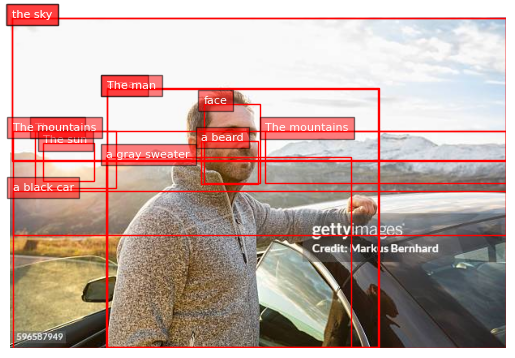

In [106]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])